In [284]:
%matplotlib notebook
from pylab import *
from scipy.constants import hbar, c, N_A, h, eV, angstrom, k
from IPython.display import display, Latex
import ipywidgets as widgets

In [285]:
# original data; not needed now
k0 = 1235
omega = 1730
w0x0 = 14.1
De = 7.37
beta = 2.73


In [299]:
from collections import namedtuple
molecule = namedtuple('molecule', 'we, wexe, re, mu, D0')
diatomics = {}
diatomics['N2'] = {'symbol': r'$^{14}N_2$', 'data': molecule(2358.57, 14.324, 1.09769, 7.001537, 9.759)}
diatomics['orig'] = {'symbol': r'$^{14}N_2$', 'data': molecule(1730, 14.1, 1.09, 7.001537, 7.263)}
diatomics['HCl'] = {'symbol': r'$^1H^{35}Cl$', 'data': molecule(2990.95, 52.819, 1.27455, 0.979593, 4.434)}
diatomics['Br2'] = {'symbol': r'$^{81}Br_2$', 'data': molecule(325.321, 1.077, 2.2810, 39.459166, 1.9707)}
diatomics['C2'] = {'symbol': r'$^{12}C_2$', 'data': molecule(1854.71, 13.34, 1.2425, 6.0, 6.21)}
diatomics['CO'] = {'symbol': r'$^{12}C^{16}O$', 'data': molecule(2169.814, 13.288, 1.12832, 6.856209, 11.09)}
diatomics['HBr'] = {'symbol': r'$^1H^{81}Br$', 'data': molecule(2648.98, 45.208, 1.141443, 0.995427, 3.758)}
diatomics['HI'] = {'symbol': r'$^1H^{127}I$', 'data': molecule(2309.01, 39.644, 1.60916, 0.999884, 3.054)}
diatomics['OH'] = {'symbol': r'$^{16}O^1H$', 'data': molecule(3737.76, 84.811, 0.96966, 0.948087, 4.392)}
diatomics['I2'] = {'symbol': r'$^{127}I_2$', 'data': molecule(214.5, 0.614, 2.666, 63.452238, 1.54238)}
diatomics['O2'] = {'symbol': r'$^{16}O_2$', 'data': molecule(1580.19, 11.98, 1.20752, 7.997458, 5.115)}
diatomics['NO'] = {'symbol': r'$^{14}N^{16}O$', 'data': molecule(1904.04, 14.100, 1.15077, 7.466433, 6.496)}

def getConstants(molecule = 'orig'):
    mol = diatomics[molecule]['data']
    mu = mol.mu / (N_A*1000)
    k0 = 4*pi**2*mu*c**2*mol.we**2*1e4
    D = (mol.D0*eV/(h*c*100) + 0.5*mol.we - 0.25*mol.wexe)*h*c*100
    beta = mol.we / sqrt(D/(2*pi**2*c**2*mu)) / 1e8
    D = D/eV
    return D, beta, k0

D, beta, k0 = getConstants('orig')
mol = diatomics['orig']['data']


## Plot Morse Potential fit to various diatomics 
### Compare to Harmonic Oscillator

<IPython.core.display.Javascript object>


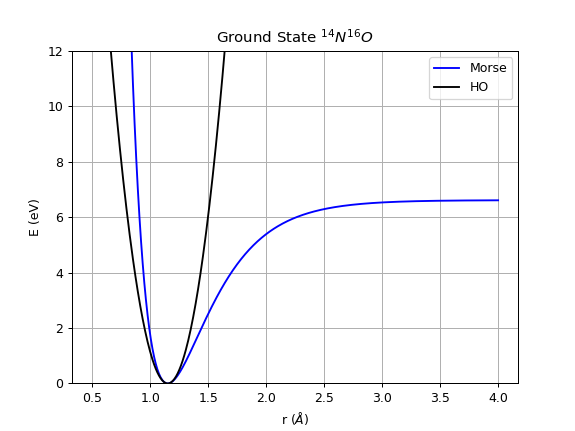

In [300]:
def getMu(m1, m2):
    return m1 * m2 / (m1 + m2)

def Morse(r, re = mol.re, beta = beta, De = D):
    return De * (1 - exp(-beta*(r-re)))**2

def E_Morse(n, w = mol.we, w0x0 = mol.wexe):
    return (h*c*100/eV)*(w*(n+0.5) - w0x0*(n+0.5)**2)

def E_HO(n, w = mol.we):
    return (h*c*100/eV) * w * (n+0.5)

def kHarm(x, k = k0, re = mol.re):
    return 0.5*k*(x-re)**2*angstrom**2/eV
    
#def getEndPoints(E):
#    return fsolve(lambda x: Morse(x) - E, [0.9, 1.1])
def getEndPoints(E, re = mol.re, D = D, beta = beta):
    distR = log(1-sqrt(E/D))/beta
    distL = log(1+sqrt(E/D))/beta
    return re - distL, re - distR

def get_tps(E, k = k0, re = mol.re):
    dist = sqrt(2*E*eV/k)/angstrom
    return re-dist, re+dist

fig = figure("Diatomic Potentials")
r = linspace(0.5, 4, 500)
def makePlot(name = 'orig', showMorse = True, showHO = False, showkT = False, nMorse = 0, nHO = 0):
    mol = diatomics[name]['data']
    symbol = diatomics[name]['symbol']
    D, beta, k0 = getConstants(name)
    ax = fig.gca()
    ax.cla()
    if showMorse:
        plot(r, Morse(r, mol.re, beta, D), 'b', label = "Morse")
    if showHO:
        plot(r, kHarm(r, k0, mol.re), 'k', label = "HO")
        
    for n in range(nMorse):
        E = E_Morse(n, mol.we, mol.wexe)
        x = getEndPoints(E, mol.re, D, beta)
        plot(x, [E, E], 'b')
        
    for n in range(nHO):
        E = E_HO(n, mol.we)
        x = get_tps(E, k0, mol.re)
        plot(x, [E, E], 'k--')
    if showkT:   
        E0 = E_HO(0, mol.we)
        kT = k * 293 / eV
        kloc = mol.re 
        plot([kloc, kloc], [E0, E0 + kT], 'r', label = 'kT')
        dr = 0.003
        plot([kloc-dr, kloc+dr], [E0, E0], 'r')
        plot([kloc-dr, kloc+dr], [E0+kT, E0+kT], 'r')
        
    ylim([0, 12])
    title(r"Ground State %s" % symbol)
    ylabel("E (eV)")
    xlabel(r"r ($\AA$)")
    legend()
    grid();
  
makePlot()
N = 25
drop_layout = widgets.Layout(width = '145px')
check_layout = widgets.Layout(width = '200px')
check_Morse = widgets.Checkbox(value = True, description = "Show Morse", layout = check_layout)
check_HO = widgets.Checkbox(value = False, description = "Show HO", layout = check_layout)
check_kT = widgets.Checkbox(value = False, description = "Show kT", layout = check_layout)
label = widgets.HTML(value ="<font color=blue><b>Select Molecule:   </b></font>" )
drop_molecule = widgets.Dropdown(options = list(diatomics.keys()),  layout = drop_layout)
drop_Morse = widgets.Dropdown(options = list(range(N)), description = "# levels", layout = drop_layout)
drop_HO = widgets.Dropdown(options = list(range(N)), description = "# levels", layout = drop_layout,
                          disabled = True)

def select_data(change):
    if not check_HO.value:
        drop_HO.value = 0
        
    if not check_Morse.value:
        drop_Morse.value = 0
        
    drop_HO.disabled = not check_HO.value
    drop_Morse.disabled = not check_Morse.value
    nHO = drop_HO.value
    nMorse = drop_Morse.value
    makePlot(name = drop_molecule.value, showMorse = check_Morse.value, showHO = check_HO.value, showkT = check_kT.value,
            nHO = nHO, nMorse = nMorse)
    
check_Morse.observe(select_data, names = 'value')
check_HO.observe(select_data, names = 'value')
check_kT.observe(select_data, names = 'value')
drop_Morse.observe(select_data, names = 'value')
drop_HO.observe(select_data, names = 'value')
drop_molecule.observe(select_data, names = 'value')

# arrange widgets
H0 = widgets.HBox([label, drop_molecule])
H1 = widgets.HBox([check_Morse, drop_Morse, check_kT])
H2 = widgets.HBox([check_HO, drop_HO])
widgets.VBox([H0, H1, H2])

In [ ]:
%%html
<style>
div.input{
    display:none;
}
</style>